In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from tqdm import tqdm
import pandas as pd
import math
import random

In [2]:
def median(x):
    
    """Return a median of a numpy matrix

    Parameters:
    x (np.array): Numpy matrix to be computed

    Returns:
    float: Final median

    """
    m,n = x.shape
    middle = np.arange((m-1)>>1,(m>>1)+1)
    x = np.partition(x,middle,axis=0)
    return x[middle].median(axis=0)

def remove_outliers(data,thresh=5.0):  
    
    """Remove outliers by z-score method, you can find more information about the z-score outlier determination at 
    https://medium.com/clarusway/z-score-and-how-its-used-to-determine-an-outlier-642110f3b482

    Parameters:
    data (array): Array of float data
    thresh (float): Threshold 

    Returns:
    array: Resulting array

    """
    m = median(data)                            
    s = np.abs(data-m)                          
    return data[(s<median(s)*thresh).all(axis=1)]


def remove_outliers_quantile(df, sup_th, inf_th):
    
    """Remove outliers of an image using the quantile method, removing the x% higher values and y% lower values where
    x and y are the superior and inferior thresholds

    Parameters:
    df (pandas.DataFrame): Dataframe containing the image data, each columns must be a RGR or BGR channel
    sup_th (float): Superior percent limit in decimal form 
    inf_th (float): Inferior percent limit in decimal form 

    Returns:
    array: Resulting Blue channel
    array: Resulting Green channel
    array: Resulting Red channel

    """

    df_clean = df[((df['b'] < df['b'].quantile(sup_th)) & (df['b'] > df['b'].quantile(inf_th))) &      ((df['g'] < df['g'].quantile(sup_th)) & (df['g'] > df['g'].quantile(inf_th))) &      ((df['r'] < df['r'].quantile(sup_th)) & (df['r'] > df['r'].quantile(inf_th)))]

    b_clean = df_clean['b'].values
    g_clean = df_clean['g'].values
    r_clean = df_clean['r'].values
    
    return b_clean, g_clean, r_clean


def face_detection(img, face_detector, landmark_detector):
    
    
    """Detect faces, extract the face from image using dlib landmarks

    Parameters:
    img (np.Array): Image matrix
    face_detector (_dlib_pybind11.fhog_object_detector): Dlib face classifier
    landmark_detector (_dlib_pybind11.shape_predictor): Dlib landmarks classifier 

    Returns:
    _dlib_pybind11.rectangles: Dlib rectangles containing faces
    array: Resulting image with the isolated face on a black background

    """
    
    # Detect the face using dlib
    faces = face_detector(img, 1)
    
    
    # In this part, we will iterate over all landmarks of interest and store into a list
    landmark_tuple = []
    for k, d in enumerate(faces):
        landmarks = landmark_detector(img, d)
        for n in range(0, 81):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmark_tuple.append((x, y))

    routes = []

    for i in range(15, -1, -1):
        from_coordinate = landmark_tuple[i+1]
        to_coordinate = landmark_tuple[i]
        routes.append(from_coordinate)

    from_coordinate = landmark_tuple[0]
    to_coordinate = landmark_tuple[17]
    routes.append(from_coordinate)

    for i in range(17, 20):
        from_coordinate = landmark_tuple[i]
        to_coordinate = landmark_tuple[i+1]
        routes.append(from_coordinate)

    from_coordinate = landmark_tuple[19]
    to_coordinate = landmark_tuple[24]
    routes.append(from_coordinate)

    for i in range(24, 26):
        from_coordinate = landmark_tuple[i]
        to_coordinate = landmark_tuple[i+1]
        routes.append(from_coordinate)

    from_coordinate = landmark_tuple[26]
    to_coordinate = landmark_tuple[16]
    routes.append(from_coordinate)
    routes.append(to_coordinate)
    
    routes.append(landmark_tuple[0])
    routes.append(landmark_tuple[77])
    routes.append(landmark_tuple[68])
    routes.append(landmark_tuple[70])
    routes.append(landmark_tuple[72])
    routes.append(landmark_tuple[73])



    for i in range(0, len(routes)-1):
        from_coordinate = routes[i]
        to_coordinate = routes[i+1]

    # Creat a mask and insert the face into it
    mask = np.zeros((img.shape[0], img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)

    out = np.zeros_like(img)
    out[mask] = img[mask]
    
    return out, faces


def landmarks_detection(ac, faces, landmark_detector, out):
    
    """Detect and cover the eyes, mouth and eyebrows based on dlib landmarks

    Parameters:
    ac (np.Array): Image matrix
    faces (_dlib_pybind11.rectangles): Dlib faces rectangles
    landmark_detector (_dlib_pybind11.shape_predictor): Dlib landmarks classifier 
    out (np.Array): Isolated face on a black background

    Returns:
    np.Array: Resulting image with eyes, eyebrows and mouth covered

    """
    # In this case, we have several landmarks, we will create a list for each of them
    right_eye = []
    left_eye = []
    mouth = []
    r_eyeB = []
    l_eyeB = []

    # Iterate over all interest landmarks
    for k, d in enumerate(faces):
        landmarks = landmark_detector(img, d)
        for n in range(36, 42):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            right_eye.append((x, y))
        #    cv2.circle(ac, (x, y), 2, (255, 255, 0), -1)

        for n in range(42, 48):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            left_eye.append((x, y))
        #    cv2.circle(ac, (x, y), 2, (255, 255, 0), -1)

        for n in range(48, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            mouth.append((x, y))
         #   cv2.circle(img, (x, y), 2, (255, 255, 0), -1)

        for n in range(17, 22):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            r_eyeB.append((x, y))

        for n in range(22, 27):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            l_eyeB.append((x, y))

    # Create a mask and insert the landmarks into it
    mask = np.zeros((img.shape[0], img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(left_eye), 1)
    mask = cv2.fillConvexPoly(mask, np.array(right_eye), 1)
    mask = cv2.fillConvexPoly(mask, np.array(mouth), 1)
    mask = cv2.fillConvexPoly(mask, np.array(r_eyeB), 1)
    mask = cv2.fillConvexPoly(mask, np.array(l_eyeB), 1)


    mask = mask.astype(bool)
    mask = ~mask

    out_lm = np.zeros_like(out)
    out_lm[mask] = out[mask]
    return out_lm

# Extract only the skin pixels
def clean_skin_pixels(out_lm):
    
    """Remove the non-skin pixels from image matrix

    Parameters:
    out_lm (np.Array): Image matrix

    Returns:
    np.Array: Blue clannel with only skin pixels
    np.Array: Green clannel with only skin pixels
    np.Array: Red clannel with only skin pixels

    """

    b = out_lm[:,:,0].flatten()
    g = out_lm[:,:,1].flatten()
    r = out_lm[:,:,2].flatten()

    b_clean = []
    g_clean = []
    r_clean = []

    for i in range(0, len(b) - 1):
        if b[i] != 0 and g[i] != 0 and r[i] != 0:
            b_clean.append(b[i])
            g_clean.append(g[i])
            r_clean.append(r[i])
            
    return b_clean, g_clean, r_clean


def create_blank_image(b_mean, g_mean, r_mean, dim = 150):
    """Create a blank squared 150,150 image with given BRG colors 
    
    Parameters:
    b_mean (float): Blue value of image
    g_mean (float): Green value of image
    r_mean (float): Red value of image

    Returns:
    np.Array: 150x150 blank image with the given BGR color

    """
    
    
    blank_image = np.zeros((dim, dim, 3), np.uint8)
    blank_image[:,:,:] = (b_mean, g_mean, r_mean)
    #cv2.putText(blank_image, 'Mean', (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    return blank_image


# Return df containing colors except the black pixels
def colors_df(out_lm):
    """Remove the non-skin pixels from image matrix using pandas data frame

    Parameters:
    out_lm (np.Array): Image matrix, must be in BGR format

    Returns:
    pandas.DataFrame: Data frame containing BGR channels with only skin pixels 

    """
    
    
    b = out_lm[:,:,0].flatten()
    g = out_lm[:,:,1].flatten()
    r = out_lm[:,:,2].flatten()


    df = pd.DataFrame({'b': b, 'g': g, 'r': r})

    return df

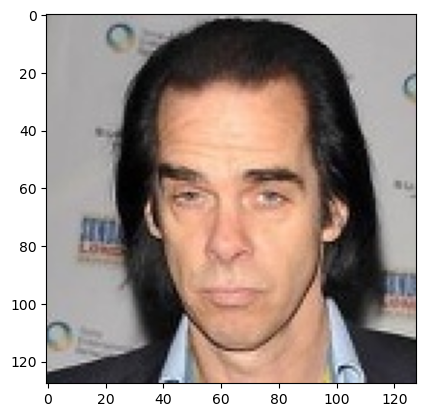

In [22]:
img = cv2.cvtColor(cv2.imread('000724.jpg'), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [23]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor('shape_predictor_81_face_landmarks.dat')

In [24]:
out, faces = face_detection(img, face_detector, landmark_detector)
#Extract facial landmarks
out_lm = landmarks_detection(img, faces, landmark_detector, out)


# Remove non-skin pixels
df = colors_df(out_lm)

# Remove outliers (10% higher and lower values)
b_clean, g_clean, r_clean = remove_outliers_quantile(df, .9, .1)

# Get the mean value of each channel
b_mean = np.mean(b_clean)
g_mean = np.mean(g_clean)
r_mean = np.mean(r_clean)

# Create the rectangle with the final skin color
square_size = 400
blank_image = create_blank_image(b_mean, g_mean, r_mean, 10)

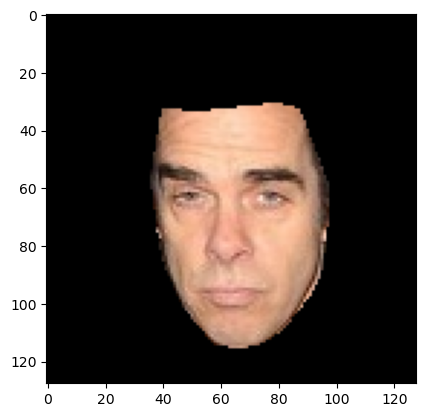

In [25]:
plt.imshow(out)
plt.show()

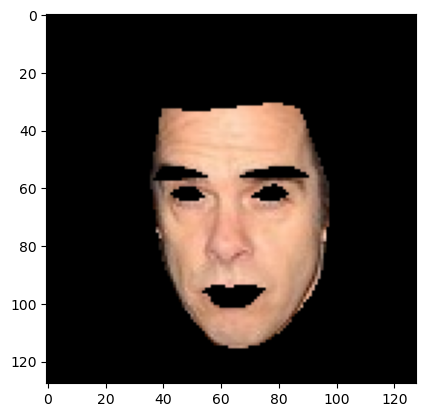

In [26]:
plt.imshow(out_lm)
plt.show()

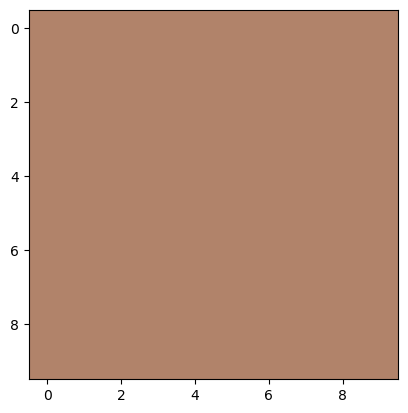

In [27]:
plt.imshow(blank_image)
plt.show()

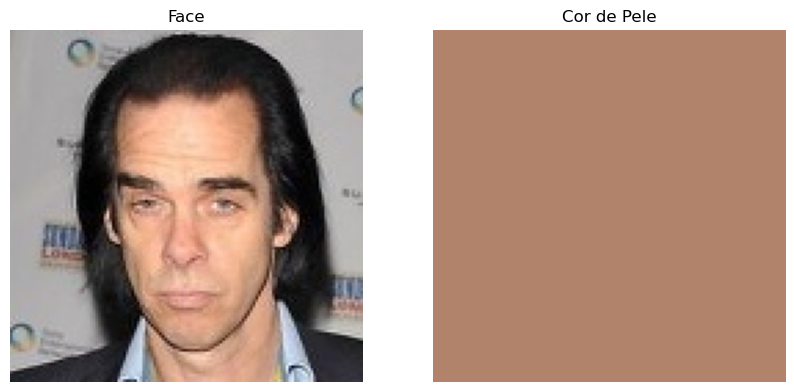

In [28]:
plt.figure(figsize=(10, 5))

# Imagem 1
plt.subplot(1, 2, 1)
plt.title('Face')
plt.imshow(img)
plt.axis('off')

# Imagem 2
plt.subplot(1, 2, 2)
plt.title('Cor de Pele')
plt.imshow(blank_image)
plt.axis('off')

# Mostrar a figura
plt.show()

# Dealing with the clothes

In [11]:
clothes_folder = 'clothing-dataset-small/'

clothes_classes = [i for i in os.listdir(clothes_folder) if '.' not in i]
clothes_classes

['skirt',
 'longsleeve',
 'dress',
 'pants',
 't-shirt',
 'shorts',
 'hat',
 'shoes',
 'shirt',
 'outwear']

In [12]:
clothes_class = 'shirt'
clothes_class_folder = clothes_folder + clothes_class + '/'

clothes_imgs_names = os.listdir(clothes_class_folder)

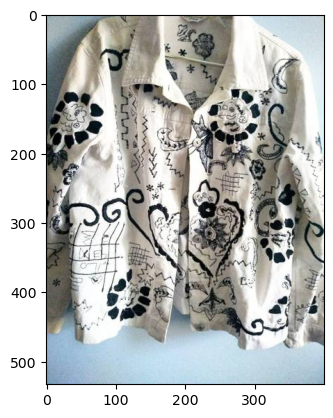

In [23]:
clothe_path = clothes_class_folder + clothes_imgs_names[0]

clothe_img = cv2.cvtColor(cv2.imread(clothe_path), cv2.COLOR_BGR2RGB)

plt.imshow(clothe_img)
plt.show()

DEBUG: path to be checked: /Users/zerk/.u2net/u2net.pth


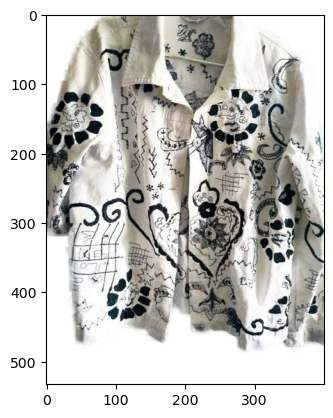

In [26]:
import cv2
import numpy as np



# Example usage
output_image = remove_bg_cv2(clothe_img)
plt.imshow(output_image)
plt.show()

(533, 400, 4)